In [1]:
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
from torchmetrics.functional.text.rouge import rouge_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import subprocess

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = pd.read_csv("split_0.csv", sep=",")
id_map = pd.read_csv('id_maps.tsv', sep="\t", header=None)
with open("uniref50_gpt_data.pkl", "rb") as f:
    pika = pickle.load(f)

In [3]:
seqs = {k: v["sequence"] for k, v in pika.items()}
next(iter(seqs.items()))

('A0A009IHW8',
 'MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENARIQSKLSDLQKKKIDIDNKLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIKASTQYITDVSISSYNNTIPETEPEYDLFISHASEDKEDFVRPLAETLQQLGVNVWYDEFTLKVGDSLRQKIDSGLRNSKYGTVVLSTDFIKKDWTNYELDGLVAREMNGHKMILPIWHKITKNDVLDYSPNLADKVALNTSVNSIEEIAHQLADVILNR')

In [4]:
split["sequence"] = split.uniprot_id.map(seqs)
split

,uniprot_id,protein_length,uniref_id,split,sequence
0,A2YUL5,389,UniRef50_Q6Z256,train,MDSGNVVVCDNGTGYVKCGFAGENFPTSVFPCVVGRPLLRYEESLQ...
1,Q07646,335,UniRef50_Q07646,test,MVRRDRLRRMREWWVQVGLLAVPLLAAYLHIPPPQLSPALHSWKTS...
2,A4WMD4,264,UniRef50_A4WMD4,train,MPDKKRRVTDFVKGGGPYVWVTAYDYPTAKLVDEAGVDGILVGDSL...
3,O07165,170,UniRef50_O07165,train,MRVEGQLGDEVVTIKATSIARRLHGKSHYGKMYEDRLQLSLIEAAY...
4,Q3UV31,285,UniRef50_Q3UV31,train,MVHKKRGGVTSWLFRKSPVHNVLPLLHSWESCHQATGCGVQLCHPT...
...,...,...,...,...,...
252598,Q9NS28,235,UniRef50_Q9NS28,train,METTLLFFSQINMCESKEKTFFKLIHGSGKEETSKEAKIRAKEKRN...
252599,Q9TTU2,172,UniRef50_Q8VCP8,train,MRLPNILLTGTPGVGKTTLGKELASRSGLKYVNVGDLAREGELYDG...
252600,Q7TTW6,268,UniRef50_Q7V8W2,train,MAERTLVGLALKVGPLGEHDRLLSLLSDAEGVTRLAVPGARRPKSS...
252601,O00399,190,UniRef50_O00399,train,MAEKTQKSVKIAPGAVVCVESEIRGDVTIGPRTVIHPKARIIAEAG...


In [5]:
cmd = ["jackhmmer", "--cpu", "4", "-N", "5", "-E", "1", "--tblout", "hmmer/jack_out.txt", "hmmer/query.fa", "hmmer/ref.fa"]
all_matches = []
df = split.copy()
seed = 0
np.random.seed(seed)
tt = len(df)
progress = tqdm(total=tt)
while len(df) > 0:
    if len(df) > 1:
        g = np.random.choice(df["uniprot_id"], 1)[0]
        with open("hmmer/query.fa", 'w') as f:
            _d = df[df.uniprot_id == g]
            if len(_d) != 1:
                print(f"issue with {g}")
            f.write(f">{_d.uniprot_id.item()}\n{_d.sequence.item()}\n")
        with open("hmmer/ref.fa", 'w') as f:
            for _, row in df[df.uniprot_id != g].iterrows():
                f.write(f">{row['uniprot_id']}\n{row['sequence']}\n")

        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        try:
            res = pd.read_csv("hmmer/jack_out.txt", delim_whitespace=True, comment='#', header=None)
            matches = [g] + res[0].to_list()
        except pd.errors.EmptyDataError:
            res = pd.DataFrame()
            matches = [g]
    else:
        matches = [df.uniprot_id.item()]
    all_matches.append(matches)
    df = df[~df.uniprot_id.isin(matches)]
    progress.n = tt - len(df)
    progress.refresh()

with open(f"hmmer/evo_groups_seed_{seed}.pkl", "wb") as f:
    pickle.dump(all_matches, f)
progress.close()

100%|██████████| 252603/252603 [6:45:35<00:00, 10.38it/s]  


In [6]:
with open(f"hmmer/evo_groups_seed_0.pkl", "rb") as f:
    match_dict = pickle.load(f)
len(match_dict)

EOFError: Ran out of input

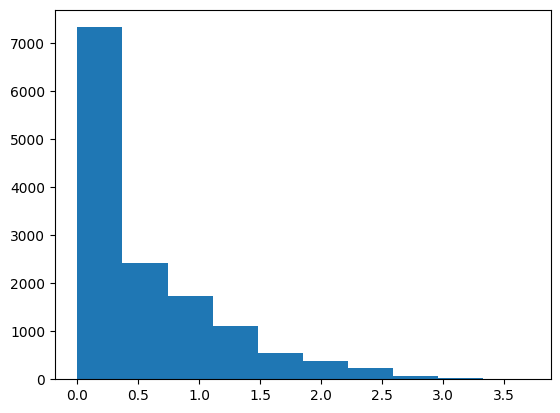

In [7]:
import matplotlib.pyplot as plt
plt.hist([np.log10(len(v)) for v in all_matches])
plt.show()

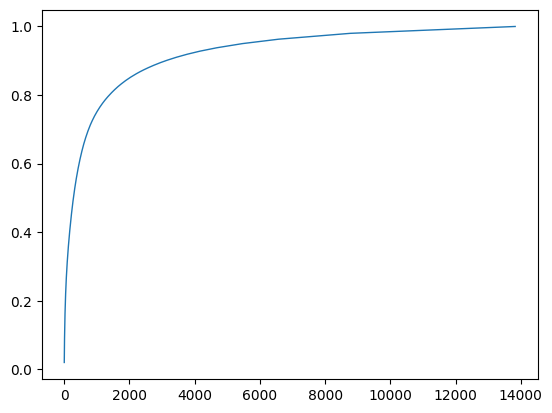

In [8]:
sizes = sorted([len(v) for v in all_matches], reverse=True)
cumsum = np.cumsum([i/sum(sizes) for i in sizes])
plt.plot(cumsum, lw=1)
plt.show()


In [ ]:
al_done = [i for j in match_dict.values() for i in j]
len(set(al_done))

238135

In [ ]:
sizes, means1, maxs1, means2, maxs2 = [], [], [], [], []
for ids in match_dict.values():
    t, l = [], []
    for i in ids:
        t.append(len(pika[i]['fields']))
        l.append(len(" ".join(pika[i]['fields'])))
    sizes.append(len(ids))
    means1.append(sum(t)/len(t))
    means2.append(sum(l)/len(l))
    maxs1.append(max(t))
    maxs2.append(max(l))


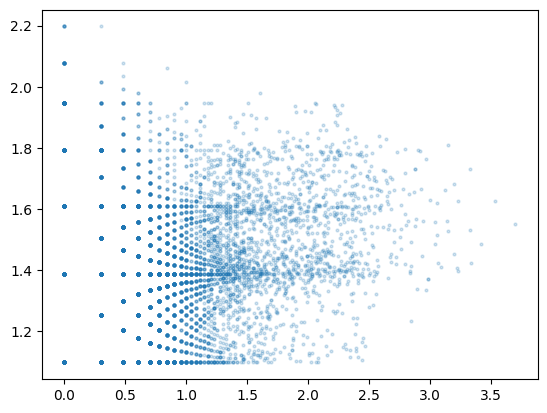

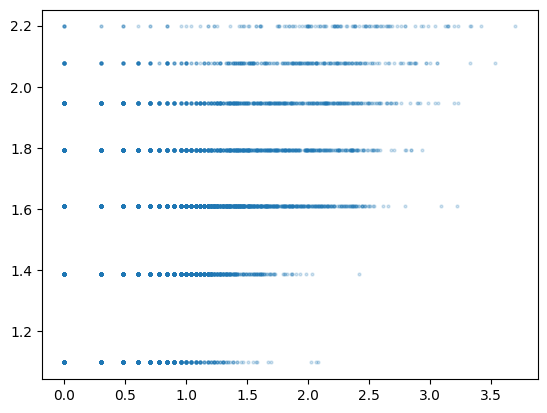

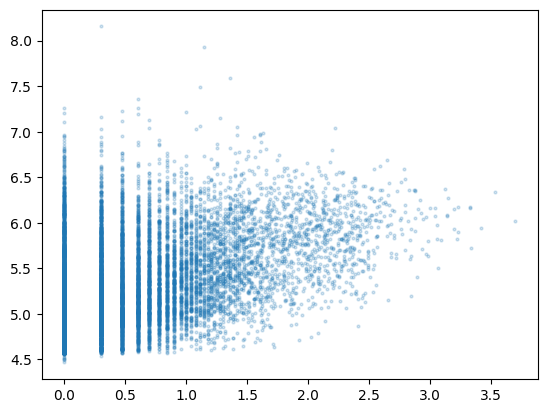

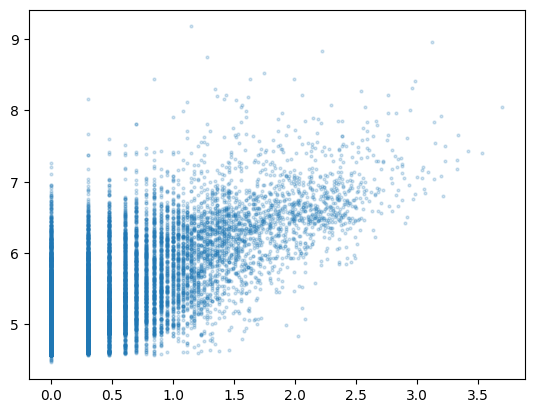

In [ ]:
for y in [means1, maxs1, means2, maxs2]:
    plt.scatter(np.log10(sizes), np.log(y), s=4, alpha=0.2)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Choose a ListedColormap
cmap = plt.cm.get_cmap('Set2')

# Get colors from the colormap
colors = cmap.colors

# Adjust alpha value to 50%
colors_with_alpha = [(r, g, b, 0.5) for r, g, b in colors]

# Using these colors for plotting
# Example: plt.scatter(x, y, color=colors_with_alpha[i])

In [ ]:
with open("prt_pca_umap.pkl", "rb") as f:
    ump = pickle.load(f)
ump

AnnData object with n_obs × n_vars = 570819 × 1024
    obs: 0
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
top100_df = id_map[id_map[2].isin(id_map[2].value_counts().iloc[:100].index.to_list())]
top100_map = {key: value for key, value in zip(top100_df[0], top100_df[2])}
ump.obs["clusters"] = ump.obs[0].map(top100_map)
ump = ump[ump.obs[0].isin(pika)].copy()

In [ ]:
ump.obs.loc[ump.obs[0].isin(), "clusters"] = "MAX"

array([nan, 'UniRef50_Q8SEL8', 'UniRef50_Q55053', 'UniRef50_P46898',
       'UniRef50_P62441', 'UniRef50_P73911', 'UniRef50_Q9CL38',
       'UniRef50_P10789', 'UniRef50_Q8RH11', 'UniRef50_Q9KA20',
       'UniRef50_C4ZCQ4', 'UniRef50_P43830', 'UniRef50_P43803',
       'UniRef50_P33038', 'UniRef50_Q83C10', 'UniRef50_A7ZHH8',
       'UniRef50_P43925', 'UniRef50_Q9AMK8', 'UniRef50_P50866',
       'UniRef50_O66962', 'UniRef50_Q5SL87', 'UniRef50_D3DKC4',
       'UniRef50_P33166', 'UniRef50_P21475', 'UniRef50_O06491',
       'UniRef50_P28595', 'UniRef50_A0QHC1', 'UniRef50_P80858',
       'UniRef50_Q7X5L3', 'UniRef50_Q5SHP8', 'UniRef50_P21466',
       'UniRef50_P08895', 'UniRef50_P13444', 'UniRef50_Q5XD01',
       'UniRef50_P56981', 'UniRef50_P15757', 'UniRef50_B1X4Y8',
       'UniRef50_B7LAV3', 'UniRef50_P80868', 'UniRef50_Q1LIF3',
       'UniRef50_Q6N4V2', 'UniRef50_P50002', 'UniRef50_P81101',
       'UniRef50_P44363', 'UniRef50_A7ZUK2', 'UniRef50_P06173',
       'UniRef50_Q13T65', 'UniRef50

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


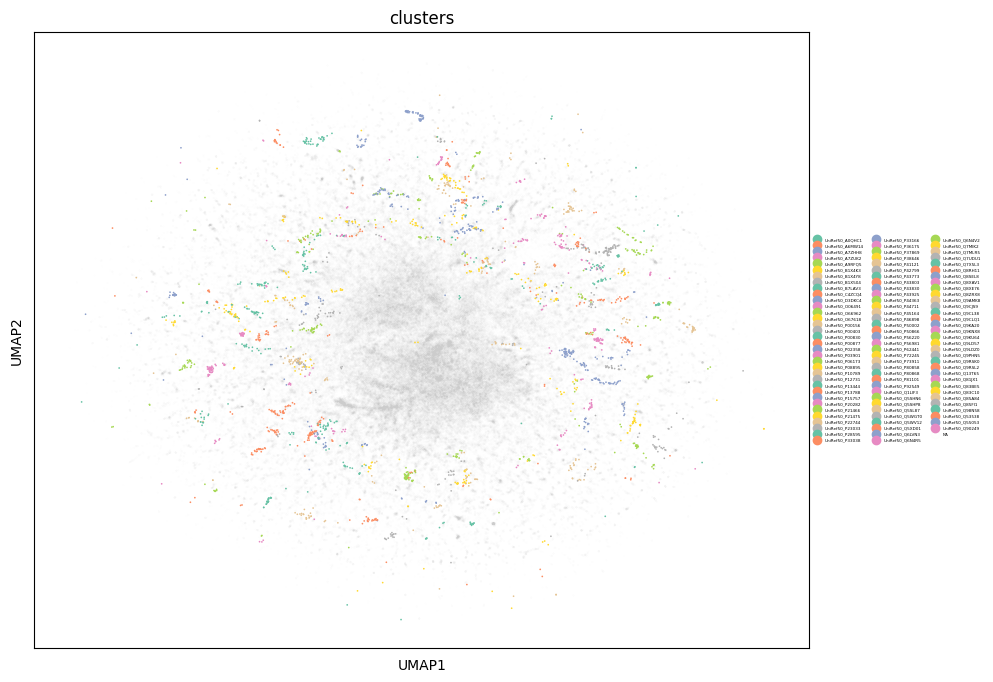

In [ ]:
with plt.rc_context({'figure.figsize':(10, 8)}):
    sc.pl.umap(ump, color="clusters", size=6, palette=colors_with_alpha, legend_fontsize=3, edges=False, na_color = (0.8, 0.8, 0.8, 0.02))

In [33]:
evo_groups = sorted(match_dict.values(), key=len, reverse=True)
len(evo_groups[0])

5003

In [51]:
_d.uniprot_id.item()

'Q9ZD67'

In [9]:
with open("test.fa", 'w') as f:
    for _, row in split[split.split == "test"].iterrows():
        f.write(f">{row['uniprot_id']}\n{row['sequence']}\n")

with open("train.fa", 'w') as f:
    for _, row in split[split.split == "train"].iterrows():
        f.write(f">{row['uniprot_id']}\n{row['sequence']}\n")

with open("val.fa", 'w') as f:
    for _, row in split[split.split == "val"].iterrows():
        f.write(f">{row['uniprot_id']}\n{row['sequence']}\n")

In [25]:
!head -6 test.fa

>Q07646
MVRRDRLRRMREWWVQVGLLAVPLLAAYLHIPPPQLSPALHSWKTSGKFFTYKGLRIFYQDSVGVVGSPEIVVLLHGFPTSSYDWYKIWEGLTLRFHRVIALDFLGFGFSDKPRPHQYSIFEQASIVESLLRHLGLQNRRINLLSHDYGDIVAQELLYRYKQNRSGRLTIKSLCLSNGGIFPETHRPLLLQKLLKDGGVLSPILTRLMNFFVFSRGLTPVFGPYTRPTESELWDMWAVIRNNDGNLVIDSLLQYINQRKKFRRRWVGALASVSIPIHFIYGPLDPINPYPEFLELYRKTLPRSTVSILDDHISHYPQLEDPMGFLNAYMGFINSF
>Q9EWW3
MTEALTHVIDHEGQGTPATVRLTVLPSGHTRVGVTDPDPRVPPLLPGPAGVTDESGRGLALLDAPAPRWGVEQRGDRRAVRCEPAGEPPLDDVRTPAAPAVRSGR
>Q54PH5
MTSKKQKSSIDTITPTPPNTTTTTTTTSTTATTKDKKKSKKPKSSGLTKVGADIIELQASLLNRPARKQATHVNSRYEDHDTDTTEYNIWYHKKLGNRNWKDRDVSETRCNVLKDCGKTRANKDANFCCYFARGKCINGADCTSLHRIPTPEDDKRLRLTHDIFGRERHKTDRDDMNGVGSFSRDNRTLYIGGIKTNVSGSLEDMVRKNFEEWGRIEYVRVITNRSISFVRYLTRSSAEFAKEAMTDQTLDNGELLNIRWATEDSNPYAKKVDERNLHRVATEVINKRIREMTPDDQSALKYQMTGQYPNTDQQYDQNGQPINASPSTPYQLQYRGSTKYEAHPYARQYNNDLQKRVQSGETVDVAPLNGVGNYYSHSVGTMNQELQKQQYDNYMQQYYQAYGYDYSKLSDDQKLQLQQYFQSYYYGNQQEQQQQETQQIQNNNENNNDNEEEDDDDEDDDDDNEDDDNDNEETKDNKNDKVENKEEENKEVQEKINTESKEDTKNEEQEKKEEKEKTDSDNIVNKED


In [32]:
!jackhmmer --cpu 60 -N 2 -E 1e-1 --tblout val_v_train.txt val.fa train.fa > /dev/null 2>&1

In [33]:
res = pd.read_csv("val_v_train.txt", delim_whitespace=True, comment='#', header=None)
columns = [
    'target_name', 'target_accession', 'query_name', 'query_accession',
    'full_seq_e-value', 'full_seq_score', 'full_seq_bias',
    'best_1_domain_e-value', 'best_1_domain_score', 'best_1_domain_bias',
    'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc',
    'description_of_target'
]
res.columns = columns
res

,target_name,target_accession,query_name,query_accession,full_seq_e-value,full_seq_score,full_seq_bias,best_1_domain_e-value,best_1_domain_score,best_1_domain_bias,exp,reg,clu,ov,env,dom,rep,inc,description_of_target
0,B1N1A3,-,P38478,-,1.500000e-171,574.9,0.5,2.000000e-171,574.5,0.5,1.1,1,0,0,1,1,1,1,-
1,P03875,-,P38478,-,1.300000e-166,558.6,11.1,1.900000e-166,558.0,11.1,1.1,1,0,0,1,1,1,1,-
2,P03876,-,P38478,-,5.200000e-159,533.5,16.1,7.800000e-159,533.0,16.1,1.1,1,0,0,1,1,1,1,-
3,P05511,-,P38478,-,4.200000e-154,517.3,4.3,6.200000e-154,516.8,4.3,1.1,1,0,0,1,1,1,1,-
4,P38456,-,P38478,-,7.800000e-110,371.3,0.3,7.900000e-72,245.9,0.0,2.4,3,0,0,3,3,2,2,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408395,Q0GA40,-,Q9XQ94,-,1.600000e-18,70.2,0.0,3.100000e-18,69.3,0.0,1.4,1,0,0,1,1,1,1,-
408396,Q8CIX8,-,Q9XQ94,-,9.700000e-18,67.7,0.0,2.100000e-17,66.6,0.0,1.4,1,0,0,1,1,1,1,-
408397,Q05650,-,Q9XQ94,-,7.400000e-16,61.5,0.0,1.500000e-15,60.5,0.0,1.4,1,0,0,1,1,1,1,-
408398,P15623,-,Q9XQ94,-,2.100000e-13,53.4,0.0,3.900000e-13,52.5,0.0,1.4,1,0,0,1,1,1,1,-


In [38]:
res.drop_duplicates(subset="query_name", keep="first").sort_values("full_seq_e-value")

,target_name,target_accession,query_name,query_accession,full_seq_e-value,full_seq_score,full_seq_bias,best_1_domain_e-value,best_1_domain_score,best_1_domain_bias,exp,reg,clu,ov,env,dom,rep,inc,description_of_target
124469,Q9VYA7,-,Q5JTH9,-,0.000,1957.1,9.2,0.000000e+00,1956.9,9.2,1.0,1,0,0,1,1,1,1,-
93182,P14779,-,O08394,-,0.000,1233.9,0.0,0.000000e+00,1233.8,0.0,1.0,1,0,0,1,1,1,1,-
318727,Q96RQ3,-,Q5I0C3,-,0.000,1196.7,0.8,0.000000e+00,1196.5,0.8,1.0,1,0,0,1,1,1,1,-
37202,Q05682,-,Q62736,-,0.000,1070.1,224.4,8.500000e-195,651.7,61.0,3.2,1,1,2,3,3,3,2,-
317532,Q54C85,-,Q54WT9,-,0.000,1379.6,94.7,2.700000e-268,896.5,45.7,3.0,1,1,2,3,3,2,2,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160095,Q88N45,-,P13320,-,0.038,18.3,0.0,9.500000e-02,17.0,0.0,1.7,1,0,0,1,1,1,0,-
318134,Q8U019,-,Q6B0Y6,-,0.046,17.9,1.6,1.700000e-01,16.1,1.4,2.1,1,1,0,1,1,1,0,-
129923,Q6SWC3,-,P35769,-,0.050,16.9,3.5,7.700000e-02,16.2,1.7,1.9,1,1,0,2,2,2,0,-
252920,P15928,-,Q8TAP9,-,0.054,16.9,1.8,9.400000e-02,16.1,1.8,1.3,1,0,0,1,1,1,0,-


In [12]:
res.query_name.unique()

array(['Q07646', 'Q54PH5', 'Q75FU8', 'Q9HLE5'], dtype=object)

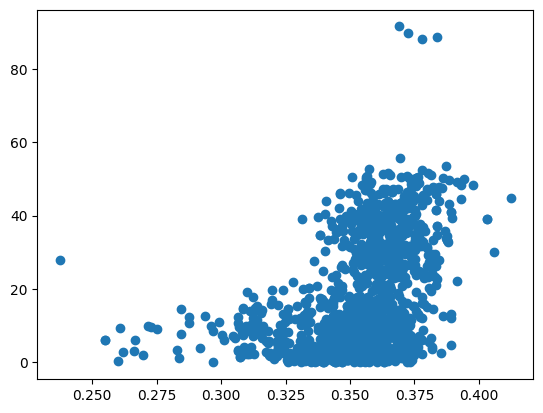

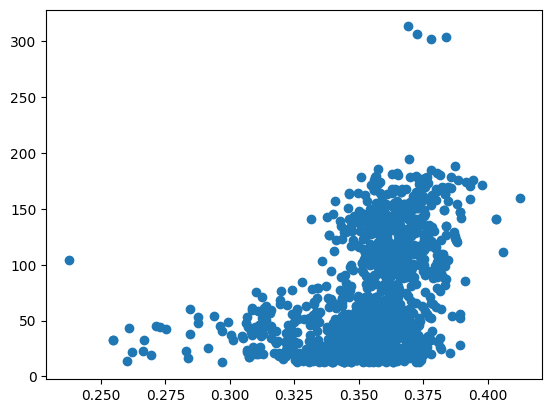

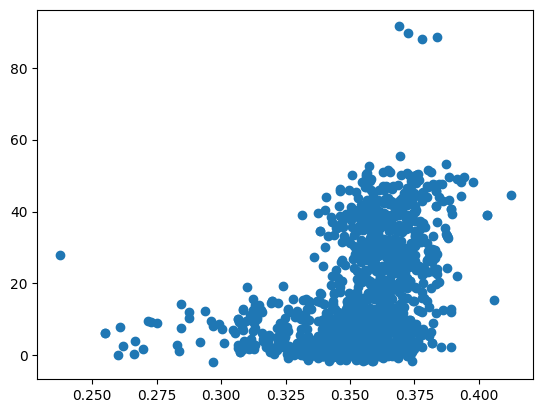

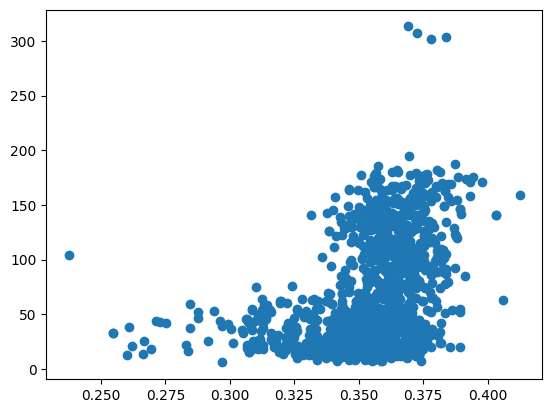

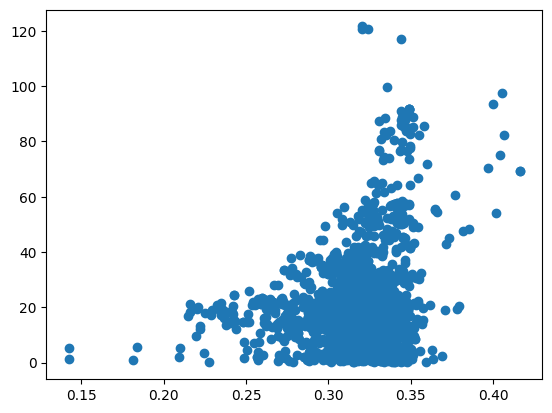

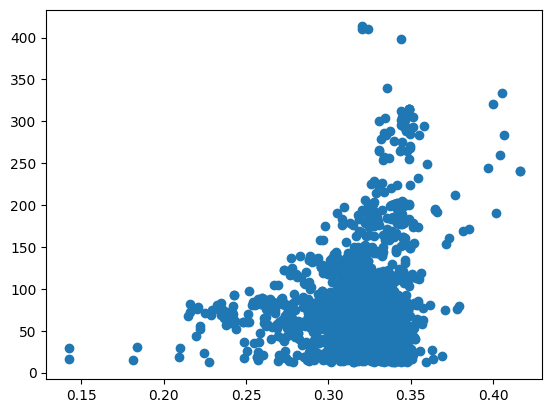

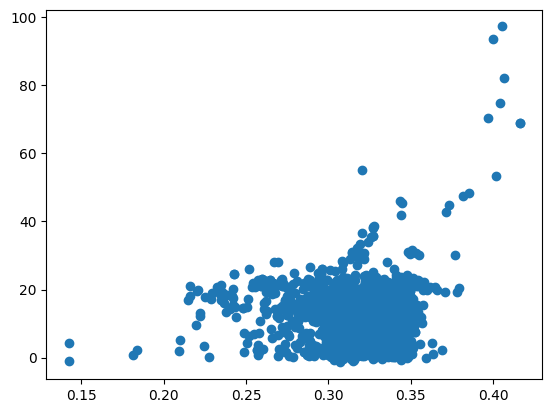

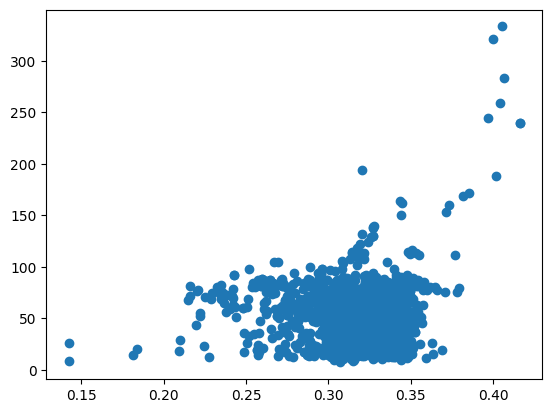

In [29]:
for q in res.query_name.unique():
    scores = []
    df = res[res.query_name == q]
    q_seq = seqs[q]
    match_seqs = [seqs[i] for i in df.target_name.to_list()]
    for s in match_seqs:
        scores.append(rouge_score(q_seq, s, tokenizer=list, rouge_keys="rougeL")['rougeL_fmeasure'].item())
    plt.scatter(scores, -np.log10(df["full_seq_e-value"]))
    plt.show()
    plt.scatter(scores, df.full_seq_score)
    plt.show()
    plt.scatter(scores, -np.log10(df["best_1_domain_e-value"]))
    plt.show()
    plt.scatter(scores, df.best_1_domain_score)
    plt.show()

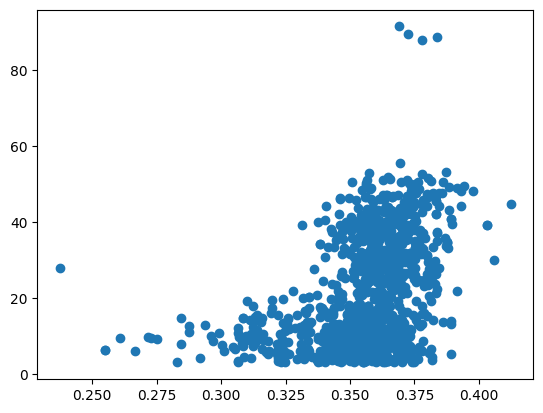

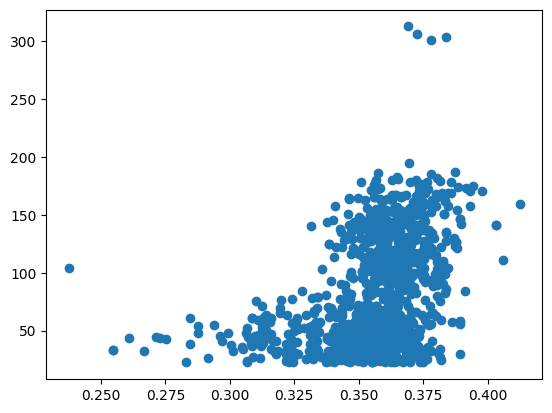

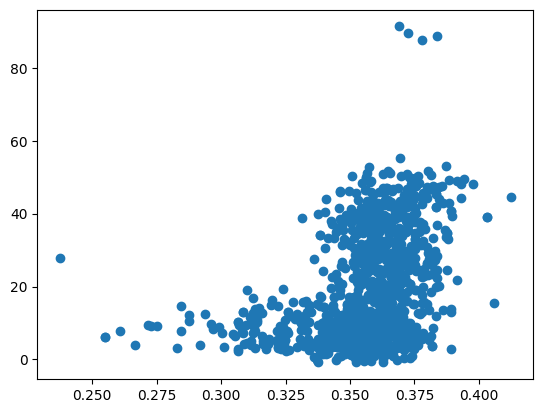

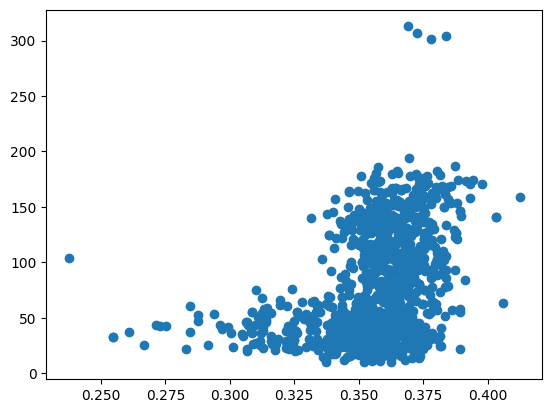

In [15]:
plt.scatter(scores, -np.log10(df["full_seq_e-value"]))
plt.show()
plt.scatter(scores, df.full_seq_score)
plt.show()
plt.scatter(scores, -np.log10(df["best_1_domain_e-value"]))
plt.show()
plt.scatter(scores, df.best_1_domain_score)
plt.show()